Optimaler Alpha-Wert: 11.513953993264458
Überprüfe Datum: 2016-01-15
Datum 2016-01-15 nicht in Daten vorhanden.
Tatsächliche vorhandene Daten: [datetime.date(2016, 4, 1) datetime.date(2016, 4, 2)
 datetime.date(2016, 4, 3) ... datetime.date(2019, 5, 25)
 datetime.date(2019, 5, 26) datetime.date(2019, 5, 27)]
Überprüfe Datum: 2016-02-15
Datum 2016-02-15 nicht in Daten vorhanden.
Tatsächliche vorhandene Daten: [datetime.date(2016, 4, 1) datetime.date(2016, 4, 2)
 datetime.date(2016, 4, 3) ... datetime.date(2019, 5, 25)
 datetime.date(2019, 5, 26) datetime.date(2019, 5, 27)]
Überprüfe Datum: 2016-03-15
Datum 2016-03-15 nicht in Daten vorhanden.
Tatsächliche vorhandene Daten: [datetime.date(2016, 4, 1) datetime.date(2016, 4, 2)
 datetime.date(2016, 4, 3) ... datetime.date(2019, 5, 25)
 datetime.date(2019, 5, 26) datetime.date(2019, 5, 27)]
Überprüfe Datum: 2016-04-15
Generiere Vorhersage für Zeitraum: 2016-04-30 bis 2016-05-29
Überprüfe Datum: 2016-05-15
Generiere Vorhersage für Zeitraum: 

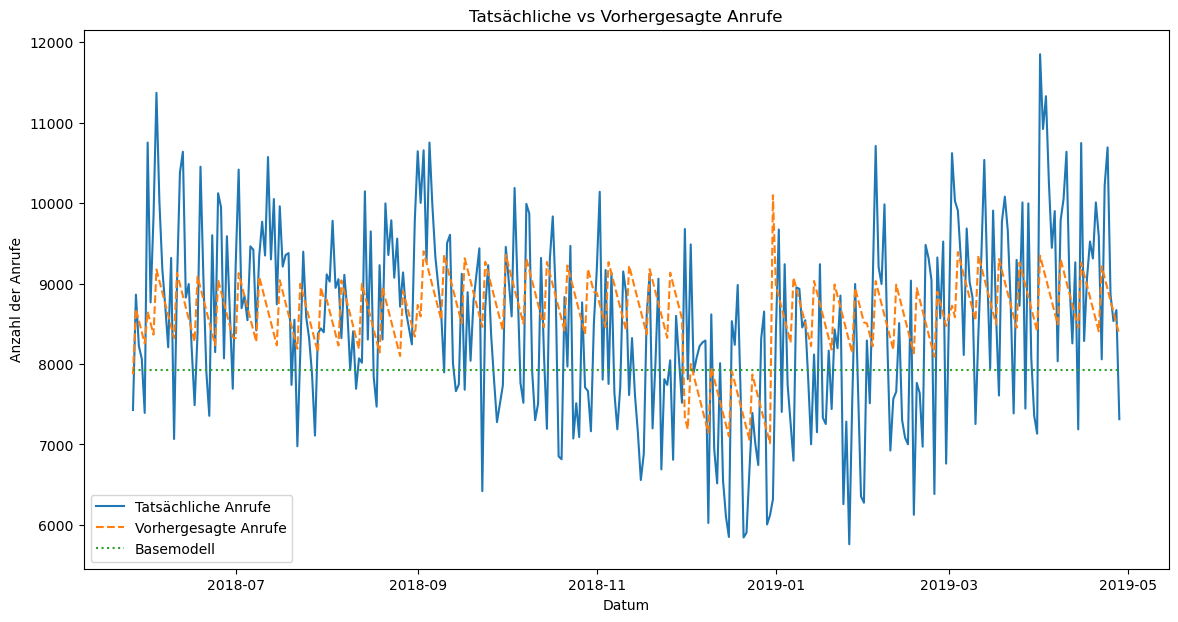

In [19]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Angenommen, du hast X_train und y_train bereits definiert

# Skalierung der Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Definiere den Parameterbereich für die Grid Search
param_grid = {'alpha': np.logspace(-4, 4, 50)}

# Führe Grid Search mit Cross-Validation durch und erhöhe max_iter
grid_search = GridSearchCV(Lasso(max_iter=5000), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Bestes Modell anzeigen und das Modell aktualisieren
best_alpha = grid_search.best_params_['alpha']
print(f"Optimaler Alpha-Wert: {best_alpha}")

# Lasso-Modell mit dem besten Alpha-Wert und skalierten Daten trainieren
lasso_model = Lasso(alpha=best_alpha, max_iter=5000)
lasso_model.fit(X_train_scaled, y_train)

# Vorhersagen am 15. jedes Monats mit Debugging (angepasst für zusätzliche Rückgabe von Daten)
def predict_for_next_30_days_debug(model, df, date_col='date', feature_cols=features):
    predictions = []
    prediction_dates = []
    
    for year in df['year'].unique():
        for month in range(1, 13):
            prediction_date_str = f'{year}-{month:02d}-15'
            prediction_date = datetime.strptime(prediction_date_str, '%Y-%m-%d').date()
            print(f"Überprüfe Datum: {prediction_date}")  # Debugging-Ausgabe
            
            if prediction_date in df[date_col].values:
                start_date = prediction_date + timedelta(days=15)
                end_date = start_date + timedelta(days=29)  # 29 Tage, um insgesamt 30 Tage zu haben
                print(f"Generiere Vorhersage für Zeitraum: {start_date} bis {end_date}")  # Debugging-Ausgabe
                
                if end_date <= df[date_col].max():
                    future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
                    future_df = pd.DataFrame({
                        'date': future_dates,
                        'Feiertage': 0,
                        'quarter': pd.to_datetime(future_dates).quarter,
                        'schulferien': 0,
                        'month': pd.to_datetime(future_dates).month,
                        'year': pd.to_datetime(future_dates).year,
                        'season': (pd.to_datetime(future_dates).month % 12 + 3) // 3,
                        'weekday': pd.to_datetime(future_dates).weekday,
                        'calendarweek': pd.to_datetime(future_dates).isocalendar().week
                    })
                    
                    future_X = future_df[feature_cols]
                    future_X_scaled = scaler.transform(future_X)  # Skaliere die zukünftigen Daten
                    future_pred = model.predict(future_X_scaled)
                    
                    predictions.extend(future_pred)
                    prediction_dates.extend(future_dates)
                else:
                    print(f"Enddatum {end_date} liegt außerhalb des verfügbaren Bereichs.")  # Debugging-Ausgabe
            else:
                print(f"Datum {prediction_date} nicht in Daten vorhanden.")  # Debugging-Ausgabe
                print(f"Tatsächliche vorhandene Daten: {df[date_col].values}")  # Debugging-Ausgabe
    
    return predictions, prediction_dates

# Vorhersagen generieren mit Debugging
predictions, prediction_dates = predict_for_next_30_days_debug(lasso_model, df)

# Überprüfen, ob Vorhersagen generiert wurden
if predictions and prediction_dates:
    # Ergebnisse in einem DataFrame zusammenfassen
    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'Lasso Regression': predictions
    })

    # Konvertiere die 'date'-Spalte in beiden DataFrames in datetime64[ns]
    prediction_df['date'] = pd.to_datetime(prediction_df['date'])
    test['date'] = pd.to_datetime(test['date'])

    prediction_df.to_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/prediction_callsLR.csv', index=False)
    
    # Zusammenführen mit tatsächlichen Werten
    merged_df = pd.merge(test, prediction_df, on='date', how='right')

    # Füge die Basemodell-Spalte hinzu und fülle sie mit einem festen Wert, z.B. 7919.5
    merged_df['Basemodell'] = 7919.5

    # Berechnung des MAPE für das Lasso Modell
    merged_df.dropna(subset=['calls'], inplace=True)  # Entfernen von Zeilen ohne tatsächliche Anrufe
    mape_lasso = np.mean(np.abs((merged_df['calls'] - merged_df['Lasso Regression']) / merged_df['calls'])) * 100
    print(f'Mean Absolute Percentage Error (MAPE) für das Lasso Regression Modell: {mape_lasso:.2f}%')

    # Berechnung des MAPE für das Basismodell
    mape_base = np.mean(np.abs((merged_df['calls'] - merged_df['Basemodell']) / merged_df['calls'])) * 100
    print(f'Mean Absolute Percentage Error (MAPE) für das Basismodell: {mape_base:.2f}%')
    
    # Plotten der tatsächlichen Werte und Vorhersagen
    plt.figure(figsize=(14, 7))
    plt.plot(merged_df['date'], merged_df['calls'], label='Tatsächliche Anrufe')
    plt.plot(merged_df['date'], merged_df['Lasso Regression'], label='Vorhergesagte Anrufe', linestyle='--')
    plt.plot(merged_df['date'], merged_df['Basemodell'], label='Basemodell', linestyle=':')
    plt.xlabel('Datum')
    plt.ylabel('Anzahl der Anrufe')
    plt.title('Tatsächliche vs Vorhergesagte Anrufe')
    plt.legend()
    plt.show()
else:
    print("Es wurden keine Vorhersagen generiert. Überprüfen Sie die Daten und die Filterbedingungen.")
